In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications import VGG19,ResNet152
import cv2
import os
import random
import tensorflow as tf

In [3]:
labels = ['bellflower','daisy','dandelion','tulip','sunflower','rose','lotus','iris']
img_size = 112
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
data = get_data("D:/STUDY/CODE/ML/PredFlower/Data/flowers")

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.6.0) D:\a\ope

C:\Users\Nguyen Duc Thinh\AppData\Local\Temp\ipykernel_14132\3399778719.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [5]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')

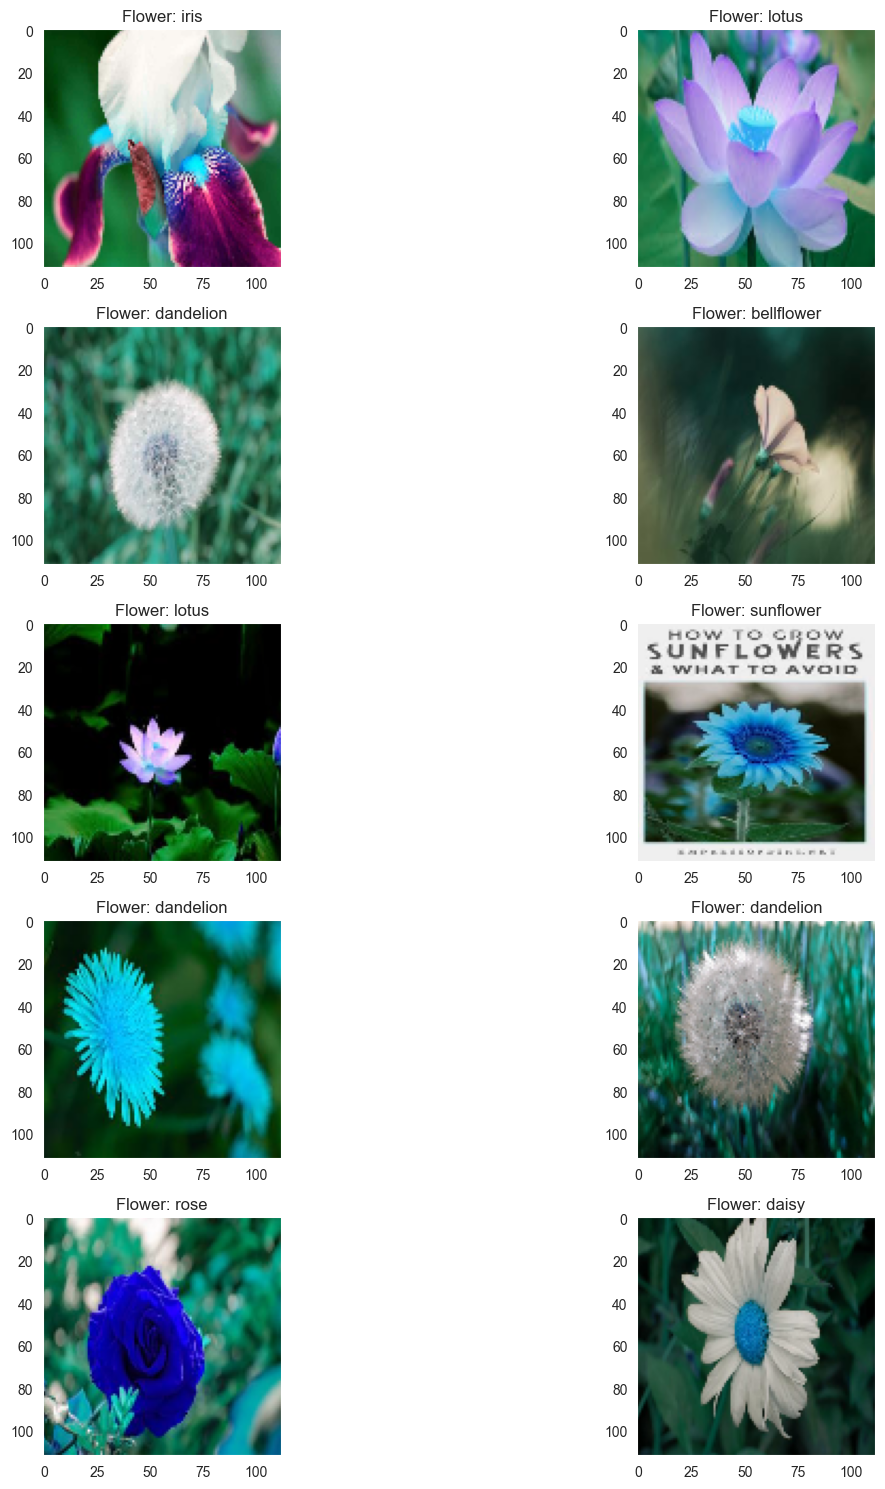

In [6]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

In [7]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [8]:
# Normalize the data
x = np.array(x) / 255

In [9]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [10]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.1 , stratify = y , random_state = 0)

In [12]:
del x,y,data

In [13]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [14]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(112,112,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(8 , activation='softmax')])
    model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 8)                 4104      
                                                                 
Total params: 20,028,488
Trainable params: 4,723,720
Non-trainable params: 15,304,768
_________________________________________________________________


In [15]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [16]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 12 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

Epoch 1/12
280/280 [==============================] - 1119s 4s/step - loss: 0.6399 - accuracy: 0.7816 - val_loss: 0.5119 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 2/12
280/280 [==============================] - 1608s 6s/step - loss: 0.3306 - accuracy: 0.8883 - val_loss: 0.3866 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 3/12
280/280 [==============================] - 1266s 5s/step - loss: 0.2166 - accuracy: 0.9274 - val_loss: 0.3981 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 4/12
280/280 [==============================] - 1432s 5s/step - loss: 0.1450 - accuracy: 0.9513 - val_loss: 0.4147 - val_accuracy: 0.8746 - lr: 0.0010
Epoch 5/12
280/280 [==============================] - 1172s 4s/step - loss: 0.1037 - accuracy: 0.9656 - val_loss: 0.4545 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 6/12
280/280 [==============================] - 1184s 4s/step - loss: 0.0555 - accuracy: 0.9816 - val_loss: 0.4584 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 7/12
280/280 [==============================] - ETA:

In [17]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

63/63 [==============================] - 104s 2s/step - loss: 0.5300 - accuracy: 0.9114
Loss of the model is -  0.5299717783927917
63/63 [==============================] - 109s 2s/step - loss: 0.5300 - accuracy: 0.9114
Accuracy of the model is -  91.13796353340149 %


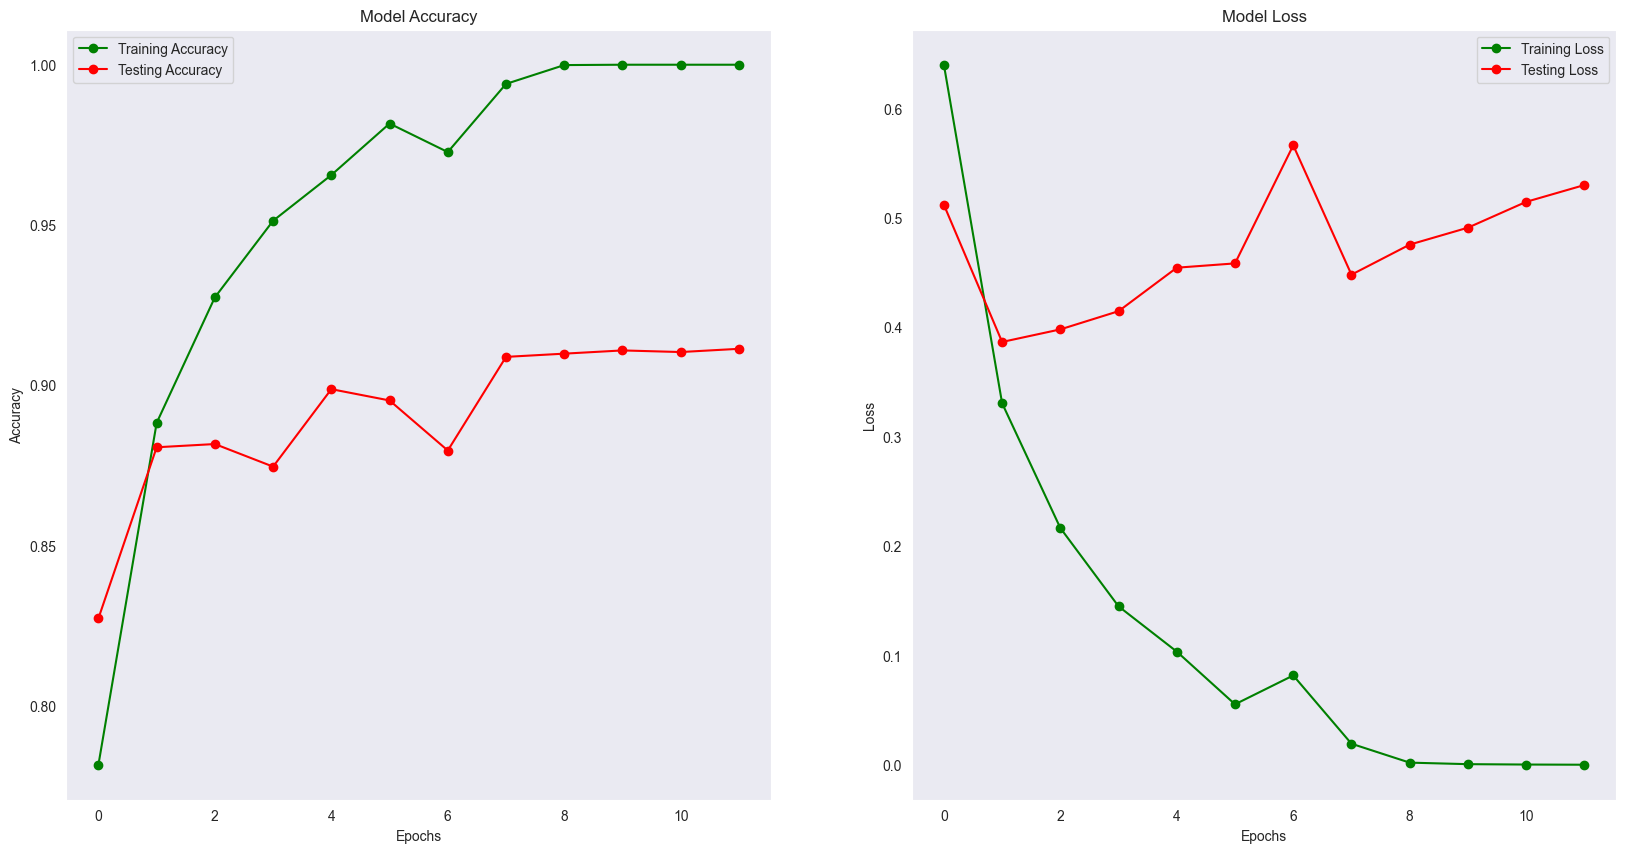

In [18]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Model Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [19]:
# predict class probabilities for x_test
class_probabilities = model.predict(x_test)
predictions = class_probabilities.argmax(axis=-1)
print(predictions[:8])

63/63 [==============================] - 122s 2s/step
[6 3 3 4 2 5 7 3]


In [20]:
y_test_inv = label_binarizer.inverse_transform(y_test)

In [21]:
report = classification_report(y_test_inv, predictions, output_dict=True, target_names = labels)
report_df = pd.DataFrame(report).transpose()
pd.set_option("display.max_rows", None)
report_df.head(134)

precision    recall  f1-score     support
bellflower     0.874016  0.891566  0.882704   249.00000
daisy          0.881148  0.870445  0.875764   247.00000
dandelion      0.932271  0.936000  0.934132   250.00000
tulip          0.887967  0.856000  0.871690   250.00000
sunflower      0.951807  0.948000  0.949900   250.00000
rose           0.876000  0.904959  0.890244   242.00000
lotus          0.931727  0.928000  0.929860   250.00000
iris           0.955645  0.955645  0.955645   248.00000
accuracy       0.911380  0.911380  0.911380     0.91138
macro avg      0.911323  0.911327  0.911242  1986.00000
weighted avg   0.911485  0.911380  0.911350  1986.00000

<AxesSubplot: >

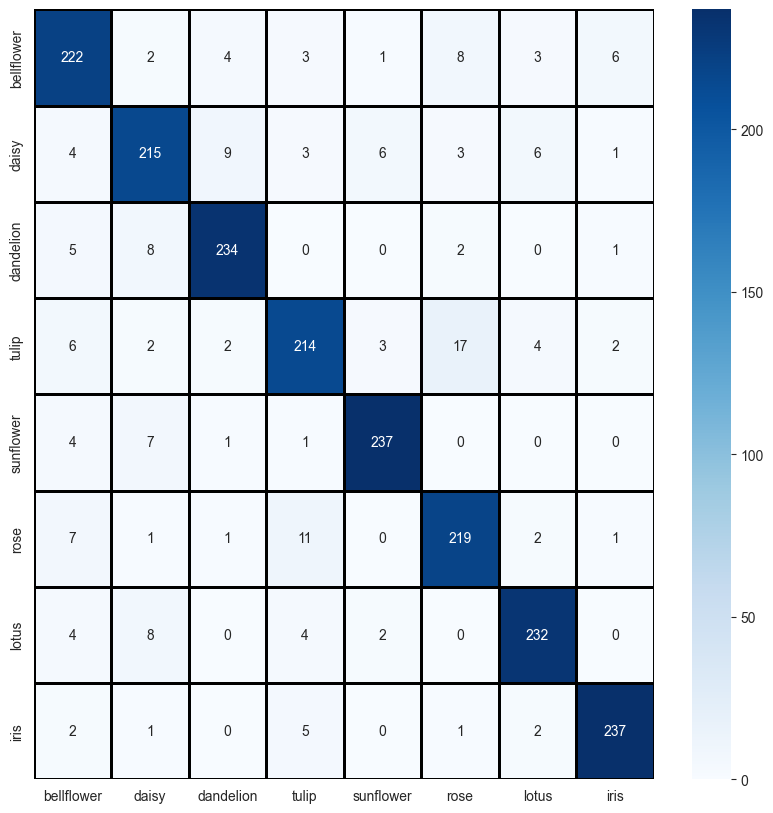

In [22]:
cm = confusion_matrix(y_test_inv,predictions)
cm = pd.DataFrame(cm , index = labels , columns = labels)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = labels , yticklabels = labels)

In [23]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_inv)):
    if(y_test_inv[i] == predictions[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test_inv)):
    if(y_test_inv[i] != predictions[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

**CORRECTLY CLASSIFIED FLOWER IMAGES**

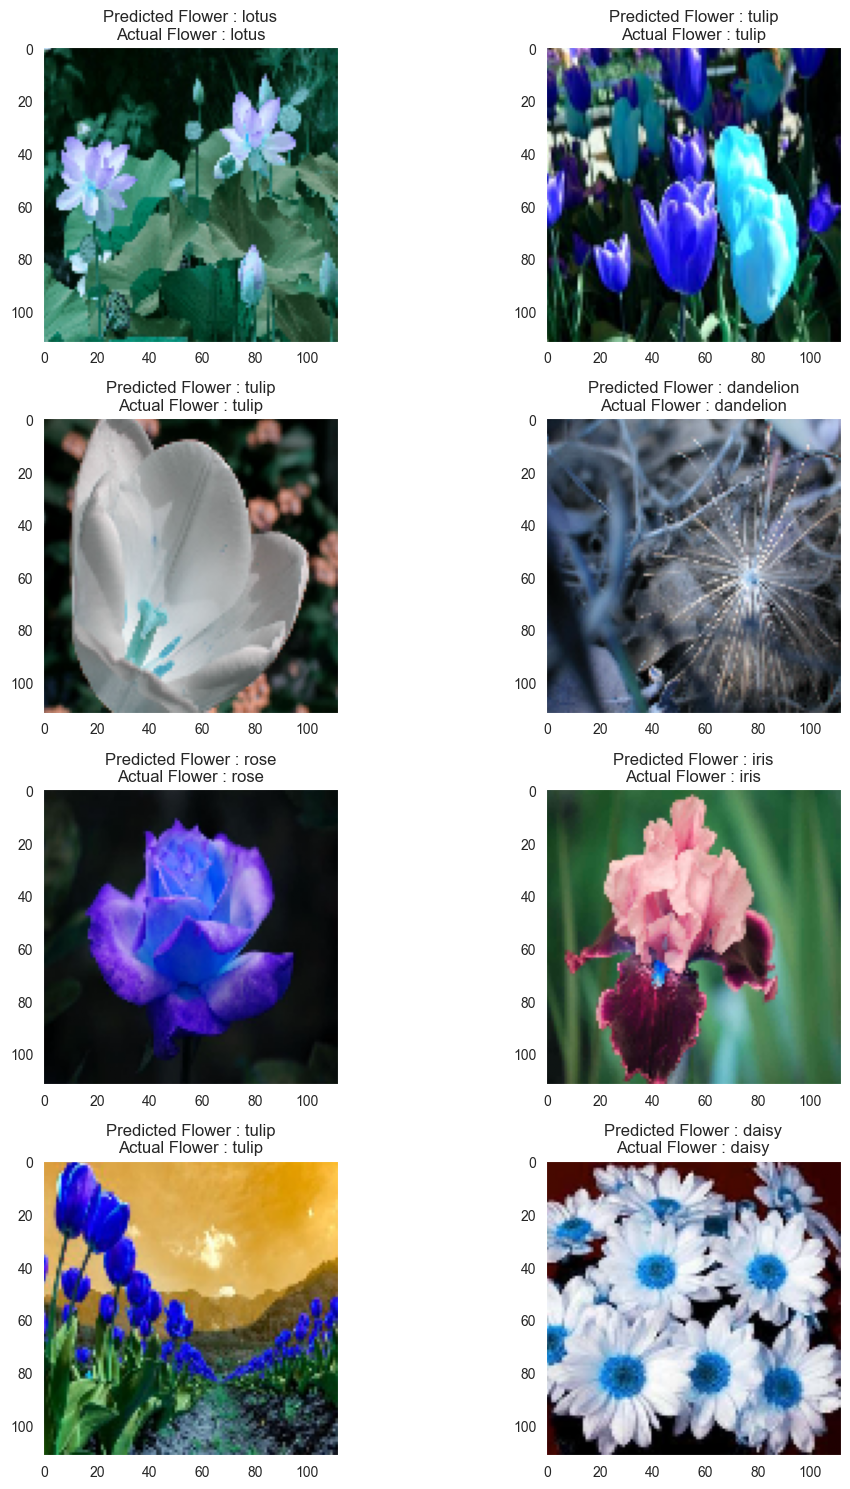

In [24]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+ labels[predictions[prop_class[count]]] +"\n"+"Actual Flower : "+ labels[y_test_inv[prop_class[count]]])
        plt.tight_layout()
        count+=1

**INCORRECTLY CLASSIFIED FLOWER IMAGES**

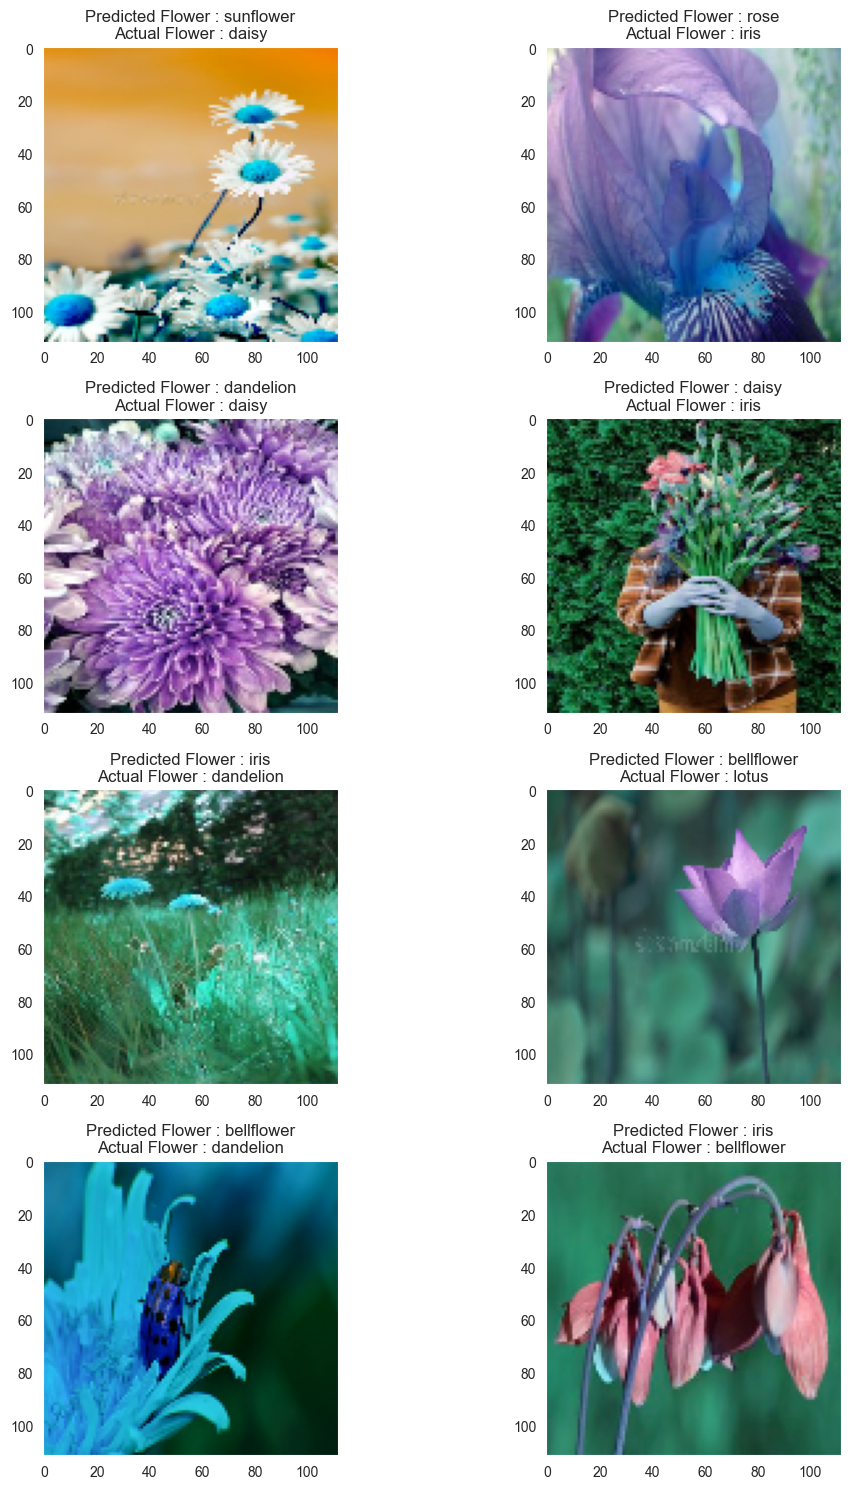

In [25]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+labels[predictions[mis_class[count]]]+"\n"+"Actual Flower : "+labels[y_test_inv[mis_class[count]]])
        plt.tight_layout()
        count+=1